# TimeQuant Quickstart

Demo of a streaming **Gaussian-Quantile tokenizer** for continuous time series.
- Univariate online tokenization with running mean/variance (Welford).
- Simple multivariate extension (per-dimension binning + k-means codebook).

> This notebook is standalone and dependency-light (NumPy & Matplotlib).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Utility: numerically stable running stats (Welford)
class RunningStats:
    def __init__(self, dim=None, eps=1e-8):
        self.n = 0
        self.mean = None if dim is None else np.zeros(dim, dtype=float)
        self.M2 = None if dim is None else np.zeros(dim, dtype=float)
        self.eps = eps

    def update(self, x):
        x = np.asarray(x)
        if self.mean is None:
            self.mean = np.zeros_like(x, dtype=float)
            self.M2 = np.zeros_like(x, dtype=float)
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    @property
    def var(self):
        if self.n < 2:
            return np.zeros_like(self.mean)
        return self.M2 / (self.n - 1)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)


class QuantileBinner:
    def __init__(self, V):
        self.V = int(V)
        # Create V-1 boundaries for V tokens (0 reserved for missing, 1 to V-1 for data)
        qs = np.linspace(0, 1, self.V)[1:-1]  # Exclude 0 and 1 to avoid inf
        self.boundaries = norm.ppf(qs).astype(np.float32)

    def encode_scalar(self, z):
        # Handle missing values first
        if np.isnan(z) or np.isinf(z):
            return 0  # Token 0 reserved for missing values
        
        # For valid data: tokens 1 to V-1
        # Find which quantile z belongs to
        idx = np.searchsorted(self.boundaries, z, side="right")
        return int(idx + 1)  # Shift by 1 to reserve token 0

    def decode_scalar(self, tok):
        if tok == 0:
            # Token 0 represents missing values - return NaN
            return np.nan
        elif tok >= self.V:
            # Invalid token - return NaN
            return np.nan
        else:
            # Valid data token (1 to V-1)
            tok_idx = tok - 1  # Convert back to 0-based index
            
            if tok_idx == 0:
                lo, hi = -np.inf, self.boundaries[0]
            elif tok_idx == len(self.boundaries):
                lo, hi = self.boundaries[-1], np.inf
            else:
                lo, hi = self.boundaries[tok_idx - 1], self.boundaries[tok_idx]

            # midpoint via CDF mid-quantile
            q_lo = 0.0 if np.isinf(lo) and lo < 0 else norm.cdf(lo)
            q_hi = 1.0 if np.isinf(hi) and hi > 0 else norm.cdf(hi)
            q_mid = 0.5 * (q_lo + q_hi)
            return norm.ppf(q_mid)


class GQTokenizer:
    def __init__(self, V, eps=1e-8):
        """
        Gaussian-Quantile Tokenizer for univariate time series.

        Args:
            V: Vocabulary size
            eps: Numerical stability parameter
        """
        self.V = V
        self.eps = eps
        self.stats = RunningStats()
        self.binner = QuantileBinner(V)

    def update(self, x):
        """Update the tokenizer with new data point."""
        self.stats.update(x)

    def encode(self, x):
        """Encode data point to token."""
        z = (x - self.stats.mean) / self.stats.std
        return self.binner.encode_scalar(float(z))

    def decode(self, tok):
        """Decode token back to data point."""
        z = self.binner.decode_scalar(tok)
        return float(self.stats.mean + z * self.stats.std)

## Core Components Explanation

### 1. RunningStats (Welford's Algorithm)
- **Purpose**: Maintains online statistics (mean, variance) for streaming data
- **Key insight**: Updates statistics incrementally without storing all data
- **Memory**: O(1) per dimension, regardless of data length
- **Numerical stability**: Uses Welford's method to avoid catastrophic cancellation

### 2. QuantileBinner
- **Purpose**: Maps standardized values to discrete tokens using Gaussian quantiles
- **Key insight**: Pre-computes quantile boundaries for N(0,1) distribution
- **Missing values**: Token 0 is reserved for NaN/inf values
- **Encoding**: Binary search to find which quantile a value belongs to
- **Decoding**: Returns midpoint of quantile interval (in z-space)

### 3. GQTokenizer (Univariate)
- **Purpose**: Complete streaming tokenizer for 1D time series
- **Process**: 
  1. Update running statistics with new data point
  2. Standardize: z = (x - mean) / std
  3. Quantize: find which Gaussian quantile z belongs to
  4. Return token ID (0 for missing, 1-V for data)
- **Decoding**: Reverse the process to get approximate original value


## 1) Univariate streaming demo

First 20 tokens: [ 8 12 13 14 14 13 13 13 12 13 13 14 14 14 14 14 15 14 14 14]


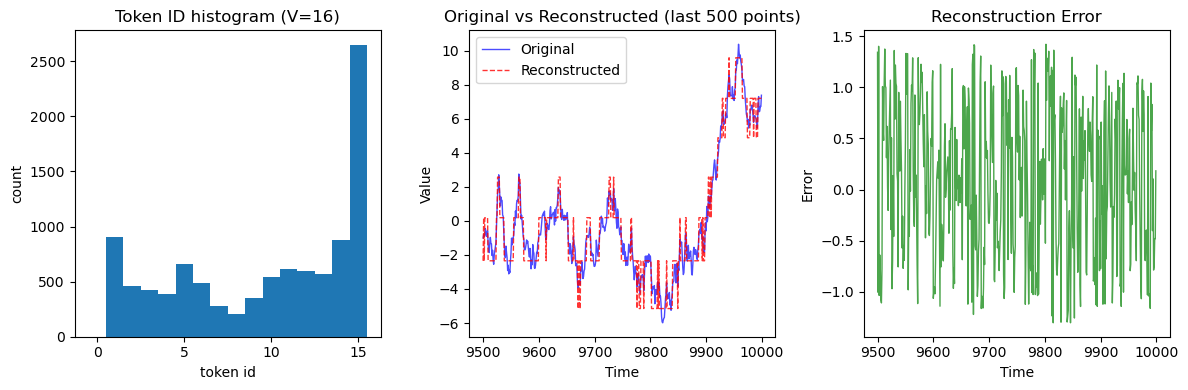

Reconstruction Statistics:
  Mean Squared Error: 89.304385
  Root Mean Squared Error: 9.450100
  Correlation (original vs reconstructed): 0.8892
  Vocabulary utilization: 15/16 tokens used


In [9]:
np.random.seed(0)
T = 10_000
# generate a nonstationary series: random walk + drift + noise
x = (
    np.cumsum(np.random.randn(T) * 0.5)
    + 0.01 * np.arange(T)
    + 0.5 * np.sin(np.arange(T) / 50)
)

V = 16
tok = GQTokenizer(V)
tokens = np.empty(T, dtype=int)
for t in range(T):
    tok.update(x[t])
    tokens[t] = tok.encode(x[t])

print("First 20 tokens:", tokens[:20])

# Decode tokens back to approximate original values
x_reconstructed = np.array([tok.decode(token) for token in tokens])

# Plot token histogram
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
bins = np.arange(V+1) - 0.5
plt.hist(tokens, bins=bins)
plt.title(f"Token ID histogram (V={V})")
plt.xlabel("token id")
plt.ylabel("count")

# Plot original vs reconstructed
plt.subplot(1, 3, 2)
time_range = slice(-500, T)  # Show last 500 points
plt.plot(np.arange(T)[time_range], x[time_range], 'b-', alpha=0.7, label='Original', linewidth=1)
plt.plot(np.arange(T)[time_range], x_reconstructed[time_range], 'r--', alpha=0.8, label='Reconstructed', linewidth=1)
plt.title("Original vs Reconstructed (last 500 points)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# Plot reconstruction error
plt.subplot(1, 3, 3)
reconstruction_error = x - x_reconstructed
plt.plot(np.arange(T)[time_range], reconstruction_error[time_range], 'g-', alpha=0.7, linewidth=1)
plt.title("Reconstruction Error")
plt.xlabel("Time")
plt.ylabel("Error")

plt.tight_layout()
plt.show()

# Print statistics
mse = np.mean(reconstruction_error**2)
print(f"Reconstruction Statistics:")
print(f"  Mean Squared Error: {mse:.6f}")
print(f"  Root Mean Squared Error: {np.sqrt(mse):.6f}")
print(f"  Correlation (original vs reconstructed): {np.corrcoef(x, x_reconstructed)[0,1]:.4f}")
print(f"  Vocabulary utilization: {len(np.unique(tokens))}/{tok.V} tokens used")

## 2) Multivariate per-dimension binning + simple k-means codebook

## Multivariate Approach Explanation

### The Challenge
For D-dimensional data, if we use V_uni tokens per dimension, we get V_uni^D possible combinations. This explodes quickly:
- D=4, V_uni=2: 2^4 = 16 combinations
- D=10, V_uni=2: 2^10 = 1,024 combinations  
- D=20, V_uni=2: 2^20 = 1,048,576 combinations
- D=100, V_uni=2: 2^100 ≈ 10^30 combinations (more than atoms in universe!)

### Our Solution: Per-Dimension + Codebook
1. **Per-dimension tokenization**: Apply univariate GQ tokenizer to each dimension independently
   - Use small V_uni (typically 2-4) to keep combinations manageable
   - Each timestep becomes a D-dimensional vector of small integers
   
2. **Codebook reduction**: Use k-means clustering to reduce V_uni^D combinations to target vocabulary V
   - Learn V centroids in the D-dimensional discrete space
   - Map each vector to nearest centroid → final token ID
   - Centroids become the embeddings

### Streaming Implementation
- **Per-dimension stats**: Each dimension maintains its own running statistics
- **Codebook updates**: Use online k-means to update centroids as new data arrives
- **Memory efficient**: O(D) for stats + O(V×D) for codebook, regardless of data length


In [ ]:
class StreamingKMeans:
    """Simplified streaming k-means with random initialization and missing value handling."""
    
    def __init__(self, n_clusters, dim, learning_rate=0.1):
        self.n_clusters = n_clusters
        self.dim = dim
        self.learning_rate = learning_rate
        self.centroids = None
        self.counts = np.zeros(n_clusters)
        self.initialized = False
        
    def _initialize_centroids(self):
        """Initialize centroids randomly with good spread."""
        # Random initialization with good spread
        self.centroids = np.random.randn(self.n_clusters, self.dim).astype(float) * 2.0
        self.initialized = True
        
    def _compute_distances_masked(self, data_point, centroids):
        """Compute distances handling missing values by masking."""
        data_point = np.asarray(data_point, dtype=float)
        centroids = np.asarray(centroids, dtype=float)
        
        # Check for missing values
        valid_mask = ~np.isnan(data_point)
        
        if not np.any(valid_mask):
            # All dimensions are missing - return large distances
            return np.full(len(centroids), np.inf)
        
        if np.all(valid_mask):
            # No missing values - standard distance computation
            return np.sum((centroids - data_point)**2, axis=1)
        
        # Partial missing values - compute distances on valid dimensions only
        valid_data = data_point[valid_mask]
        valid_centroids = centroids[:, valid_mask]
        distances = np.sum((valid_centroids - valid_data)**2, axis=1)
        
        # Scale by number of valid dimensions to make distances comparable
        scale_factor = self.dim / np.sum(valid_mask)
        return distances * scale_factor
        
    def update(self, data_point):
        """Update centroids with a single data point."""
        data_point = np.asarray(data_point, dtype=float)
        
        # Initialize on first update
        if not self.initialized:
            self._initialize_centroids()
            
        # Skip update if entire vector is missing
        if np.all(np.isnan(data_point)):
            return
            
        # Find closest centroid using masked distance computation
        distances = self._compute_distances_masked(data_point, self.centroids)
        closest_idx = np.argmin(distances)
        
        # Update centroid using online learning
        self.counts[closest_idx] += 1
        alpha = self.learning_rate / np.sqrt(self.counts[closest_idx])
        
        # Only update valid dimensions
        valid_mask = ~np.isnan(data_point)
        if np.any(valid_mask):
            self.centroids[closest_idx, valid_mask] += alpha * (data_point[valid_mask] - self.centroids[closest_idx, valid_mask])
        
    def predict(self, data_point):
        """Find closest centroid for a data point, returning token 1 to n_clusters."""
        data_point = np.asarray(data_point, dtype=float)
        
        # Return token 0 if entire vector is missing
        if np.all(np.isnan(data_point)):
            return 0
            
        if not self.initialized:
            return 1  # Default to first centroid (token 1)
            
        # Compute distances and return token (1 to n_clusters)
        distances = self._compute_distances_masked(data_point, self.centroids)
        return np.argmin(distances) + 1


class MultiGQTokenizer:
    """Multivariate Gaussian-Quantile tokenizer with streaming codebook."""
    
    def __init__(self, D, V_uni=2, V_total=256, learning_rate=0.1):
        """
        Args:
            D: Number of dimensions
            V_uni: Vocabulary size per dimension (typically 2-4)
            V_total: Total vocabulary size (final tokens)
            learning_rate: Learning rate for streaming k-means
        """
        self.D = D
        self.V_uni = V_uni
        self.V_total = V_total
        
        # Per-dimension tokenizers
        self.dim_tokenizers = [GQTokenizer(V_uni) for _ in range(D)]
        
        # Streaming k-means for codebook (now operates on quantized real values)
        self.codebook = StreamingKMeans(V_total, D, learning_rate)
        
        # Track per-dimension codes for analysis
        self.recent_codes = []
        
    def update(self, x):
        """Update tokenizer with new D-dimensional data point."""
        x = np.asarray(x)
        if x.shape != (self.D,):
            raise ValueError(f"Expected shape ({self.D},), got {x.shape}")
            
        # Skip update if entire vector is missing
        if np.all(np.isnan(x)):
            return
            
        # Update per-dimension tokenizers (only for valid dimensions)
        for d in range(self.D):
            if not np.isnan(x[d]):
                self.dim_tokenizers[d].update(x[d])
            
        # Get quantized real-valued approximation 
        quantized = self.decode_vector_code(self.encode_vector_code(x))
        
        # Update codebook with the quantized real values (not integer codes!)
        self.codebook.update(quantized)
        
        # Keep recent codes for analysis (optional)
        codes = self.encode_vector_code(x)
        self.recent_codes.append(codes.copy())
        if len(self.recent_codes) > 1000:  # Keep only recent 1000
            self.recent_codes = self.recent_codes[-1000:]
            
    def encode_vector_code(self, x):
        """Encode to per-dimension codes (before codebook mapping)."""
        x = np.asarray(x)
        codes = np.empty(self.D, dtype=int)
        for d in range(self.D):
            codes[d] = self.dim_tokenizers[d].encode(x[d])
        return codes
    
    def decode_vector_code(self, codes):
        """Decode per-dimension codes back to real-valued quantized approximation."""
        codes = np.asarray(codes, dtype=int)
        quantized = np.empty(self.D)
        for d in range(self.D):
            decoded_val = self.dim_tokenizers[d].decode(codes[d])
            if np.isnan(decoded_val):
                # Handle missing values - use mean of the dimension if available
                if hasattr(self.dim_tokenizers[d].stats, 'mean') and self.dim_tokenizers[d].stats.mean is not None:
                    quantized[d] = self.dim_tokenizers[d].stats.mean
                else:
                    quantized[d] = 0.0  # Default fallback
            else:
                quantized[d] = decoded_val
        return quantized
        
    def encode(self, x):
        """Encode to final token ID."""
        x = np.asarray(x)
        
        # Return token 0 if entire vector is missing
        if np.all(np.isnan(x)):
            return 0
            
        # Get quantized real-valued approximation
        quantized = self.decode_vector_code(self.encode_vector_code(x))
        return self.codebook.predict(quantized)
        
    def decode(self, token_id):
        """Decode token ID back to approximate original values."""
        # Token 0 represents missing values
        if token_id == 0:
            return np.full(self.D, np.nan)
            
        if not self.codebook.initialized:
            return np.full(self.D, np.nan)
            
        # Get centroid for this token (tokens 1 to V_total map to centroids 0 to V_total-1)
        centroid_idx = token_id - 1
        if centroid_idx >= len(self.codebook.centroids):
            return np.full(self.D, np.nan)
            
        centroid = self.codebook.centroids[centroid_idx]
        return centroid


FULL MULTIVARIATE STREAMING DEMO
Streaming through 10,000 timesteps...
  Processed 0 timesteps...
  Processed 2,000 timesteps...
  Processed 4,000 timesteps...
  Processed 6,000 timesteps...
  Processed 8,000 timesteps...
Tokenization complete!
Decoding tokens...

Multivariate Tokenization Results:
  Dimensions: 4
  Per-dim vocab: 16 (max combinations: 65,536)
  Final vocab: 2048
  Unique tokens used: 17/2048
  Perplexity: 4.94
  Vocabulary utilization: 0.8%
  Token 0 usage: 0 (should be 0 for clean data)

Reconstruction Statistics:
  Mean Squared Error: 11.292884
  Root Mean Squared Error: 3.360489
  Dimension 0 correlation: 0.2536
  Dimension 1 correlation: 0.3607
  Dimension 2 correlation: 0.8759
  Dimension 3 correlation: 0.2114


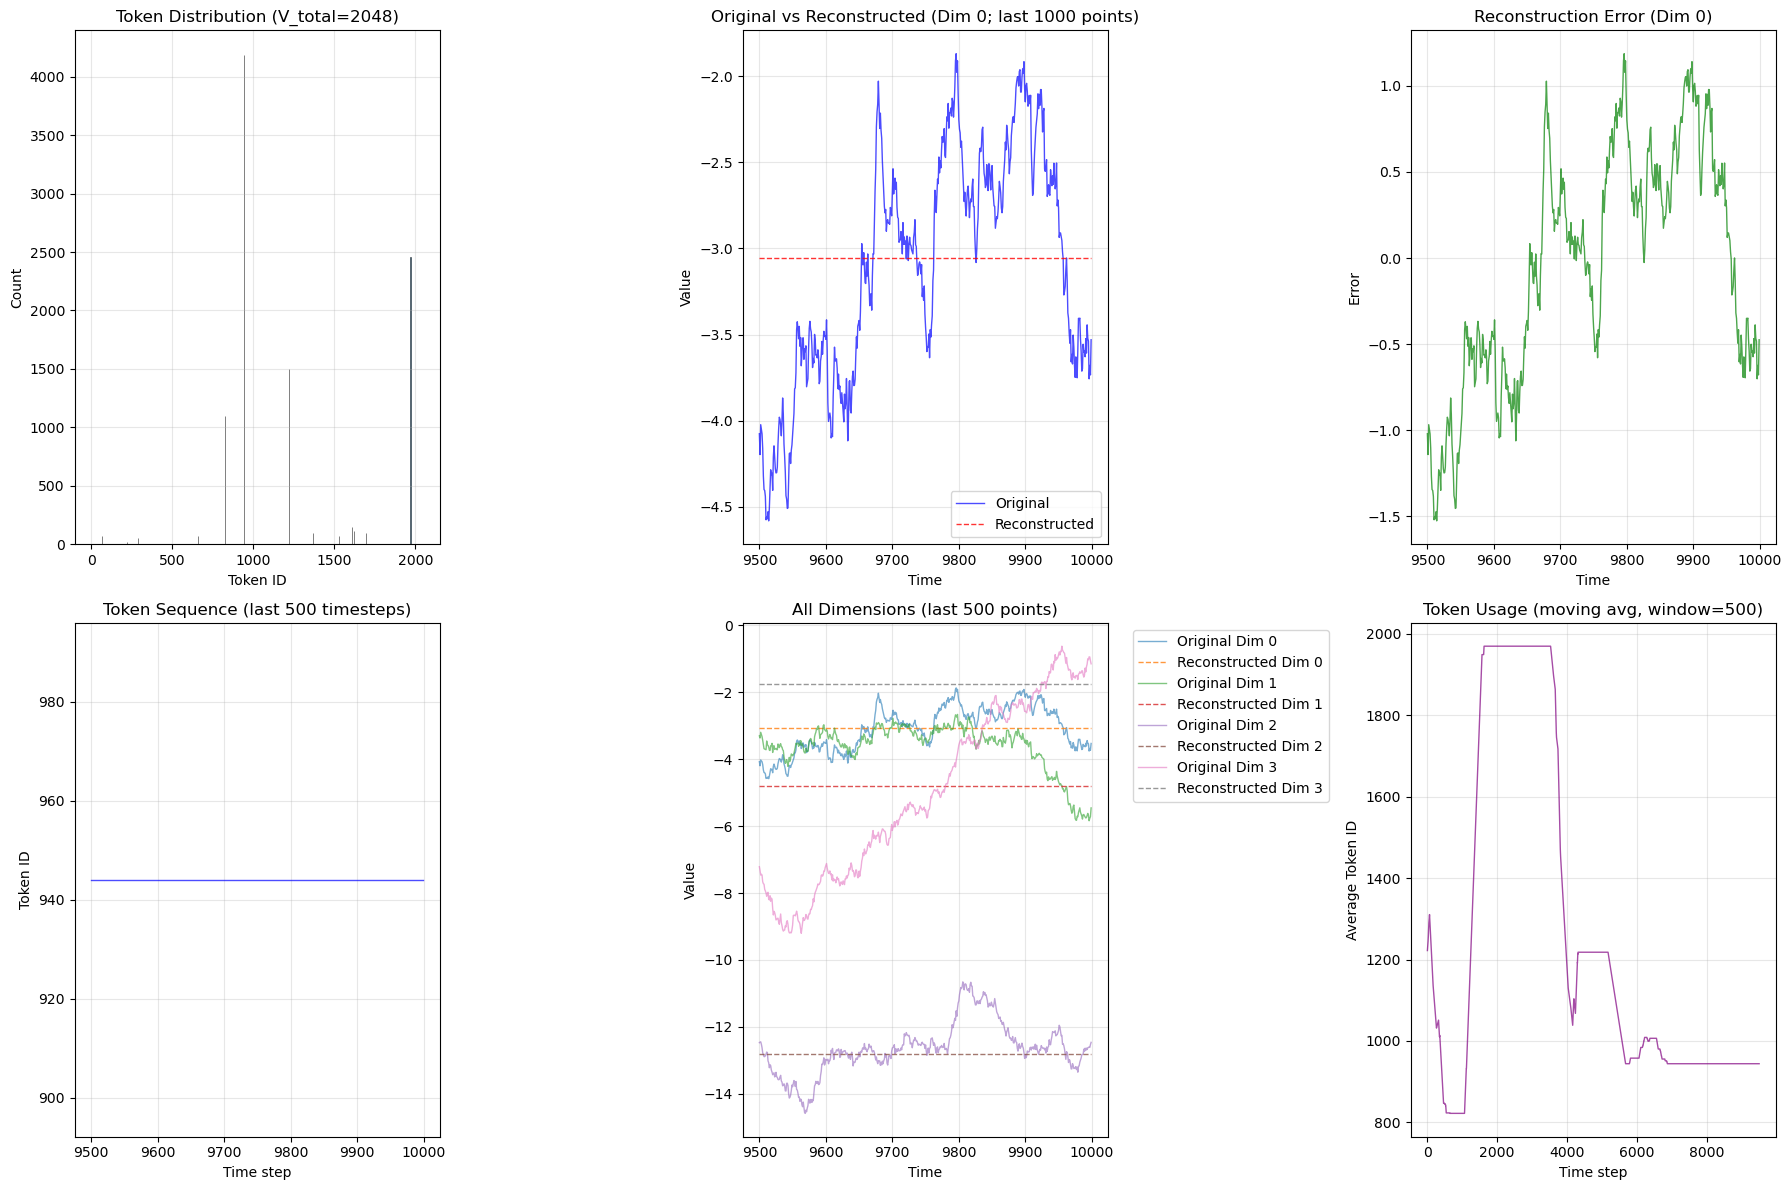


Top 10 Most Used Tokens:
  Token 944:  4188 times ( 41.9%)
  Token 1970:  2456 times ( 24.6%)
  Token 1218:  1503 times ( 15.0%)
  Token 822:  1094 times ( 10.9%)
  Token 1610:   147 times (  1.5%)
  Token 1621:   109 times (  1.1%)
  Token 1366:   100 times (  1.0%)
  Token 1696:    96 times (  1.0%)
  Token 64:    74 times (  0.7%)
  Token 1529:    71 times (  0.7%)

Compression Statistics:
  Original data size: 160,000 bytes
  Tokenized size: 40,000 bytes (token IDs)
  Codebook size: 32,768 bytes (centroids)
  Total compressed: 72,768 bytes
  Compression ratio: 45.48% of original
  Space savings: 54.5%


In [13]:
# Full Multivariate Streaming Demo (T=10,000)
print("="*60)
print("FULL MULTIVARIATE STREAMING DEMO")
print("="*60)

# Parameters for full demo
D = 4
V_uni = 16
V_total = 2048  # Final vocabulary size
T_full = 10_000

# Generate 4D correlated time series (same as before but longer)
np.random.seed(0)  # Same seed as univariate demo for consistency
cov = np.array([
    [1.0, 0.6, 0.0, 0.1],
    [0.6, 1.0, 0.2, 0.0],
    [0.0, 0.2, 1.0, 0.4],
    [0.1, 0.0, 0.4, 1.0],
])
L = np.linalg.cholesky(cov)
z = np.random.randn(T_full, D) @ L.T
X_full = (np.cumsum(z, axis=0) * 0.1) + 0.1 * np.sin(np.arange(T_full)[:, None] / 30)

# Create multivariate tokenizer
multi_tok_full = MultiGQTokenizer(D=D, V_uni=V_uni, V_total=V_total, learning_rate=1)

# Stream through data and tokenize
print(f"Streaming through {T_full:,} timesteps...")
final_tokens_full = np.empty(T_full, dtype=int)
for t in range(T_full):
    if t % 2000 == 0:
        print(f"  Processed {t:,} timesteps...")
    multi_tok_full.update(X_full[t])
    final_tokens_full[t] = multi_tok_full.encode(X_full[t])

print("Tokenization complete!")

# Decode tokens back to approximate original values
print("Decoding tokens...")
X_reconstructed_full = np.array([multi_tok_full.decode(token) for token in final_tokens_full])

# Analysis
vals, counts = np.unique(final_tokens_full, return_counts=True)
p = counts / counts.sum()
H = -(p * np.log(p + 1e-12)).sum()
perplexity = float(np.exp(H))

print(f"\nMultivariate Tokenization Results:")
print(f"  Dimensions: {D}")
print(f"  Per-dim vocab: {V_uni} (max combinations: {V_uni**D:,})")
print(f"  Final vocab: {V_total}")
print(f"  Unique tokens used: {len(vals)}/{V_total}")
print(f"  Perplexity: {perplexity:.2f}")
print(f"  Vocabulary utilization: {len(vals)/V_total*100:.1f}%")

# Check for token 0 usage
token_0_count = np.sum(final_tokens_full == 0)
print(f"  Token 0 usage: {token_0_count} (should be 0 for clean data)")

# Calculate reconstruction statistics
mse = np.mean((X_full - X_reconstructed_full)**2)
print(f"\nReconstruction Statistics:")
print(f"  Mean Squared Error: {mse:.6f}")
print(f"  Root Mean Squared Error: {np.sqrt(mse):.6f}")
for d in range(D):
    corr = np.corrcoef(X_full[:, d], X_reconstructed_full[:, d])[0, 1]
    print(f"  Dimension {d} correlation: {corr:.4f}")

# Visualization
plt.figure(figsize=(18, 12))

# 1. Token histogram
plt.subplot(2, 3, 1)
bins = np.arange(V_total + 1) - 0.5
plt.hist(final_tokens_full, bins=bins, alpha=0.7, edgecolor='black', linewidth=0.5)
plt.title(f"Token Distribution (V_total={V_total})")
plt.xlabel("Token ID")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)

# 2. Original vs reconstructed (first dimension)
plt.subplot(2, 3, 2)
time_range = slice(-500, T_full)  # Show last 500 points
plt.plot(np.arange(T_full)[time_range], X_full[time_range, 0], 'b-', alpha=0.7, label='Original', linewidth=1)
plt.plot(np.arange(T_full)[time_range], X_reconstructed_full[time_range, 0], 'r--', alpha=0.8, label='Reconstructed', linewidth=1)
plt.title("Original vs Reconstructed (Dim 0; last 1000 points)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Reconstruction error (first dimension)
plt.subplot(2, 3, 3)
reconstruction_error = X_full[:, 0] - X_reconstructed_full[:, 0]
plt.plot(np.arange(T_full)[time_range], reconstruction_error[time_range], 'g-', alpha=0.7, linewidth=1)
plt.title("Reconstruction Error (Dim 0)")
plt.xlabel("Time")
plt.ylabel("Error")
plt.grid(True, alpha=0.3)

# 4. Token sequence (last 500 timesteps)
plt.subplot(2, 3, 4)
time_range = slice(-500, T_full)
plt.plot(np.arange(T_full)[time_range], final_tokens_full[time_range], 'b-', alpha=0.7, linewidth=1)
plt.title("Token Sequence (last 500 timesteps)")
plt.xlabel("Time step")
plt.ylabel("Token ID")
plt.grid(True, alpha=0.3)

# 5. All dimensions comparison (last 500 points)
plt.subplot(2, 3, 5)
time_range_short = slice(-500, T_full)
for d in range(D):
    plt.plot(np.arange(T_full)[time_range_short], X_full[time_range_short, d], 
             alpha=0.6, linewidth=1, label=f'Original Dim {d}')
    plt.plot(np.arange(T_full)[time_range_short], X_reconstructed_full[time_range_short, d], 
             '--', alpha=0.8, linewidth=1, label=f'Reconstructed Dim {d}')
plt.title("All Dimensions (last 500 points)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 6. Token usage over time (moving average)
plt.subplot(2, 3, 6)
window_size = 500
if T_full >= window_size:
    moving_avg_tokens = np.convolve(final_tokens_full, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg_tokens, 'purple', alpha=0.7, linewidth=1)
    plt.title(f"Token Usage (moving avg, window={window_size})")
    plt.xlabel("Time step")
    plt.ylabel("Average Token ID")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show top 10 most used tokens
print(f"\nTop 10 Most Used Tokens:")
sorted_indices = np.argsort(counts)[::-1]
for i in range(min(10, len(vals))):
    idx = sorted_indices[i]
    token_id = vals[idx]
    count = counts[idx]
    percentage = count / T_full * 100
    print(f"  Token {token_id:2d}: {count:5d} times ({percentage:5.1f}%)")

# Show compression statistics
print(f"\nCompression Statistics:")
print(f"  Original data size: {T_full * D * 4:,} bytes")
print(f"  Tokenized size: {T_full * 4:,} bytes (token IDs)")
print(f"  Codebook size: {V_total * D * 4:,} bytes (centroids)")
print(f"  Total compressed: {T_full * 4 + V_total * D * 4:,} bytes")
print(f"  Compression ratio: {(T_full * 4 + V_total * D * 4) / (T_full * D * 4) * 100:.2f}% of original")
print(f"  Space savings: {(1 - (T_full * 4 + V_total * D * 4) / (T_full * D * 4)) * 100:.1f}%")


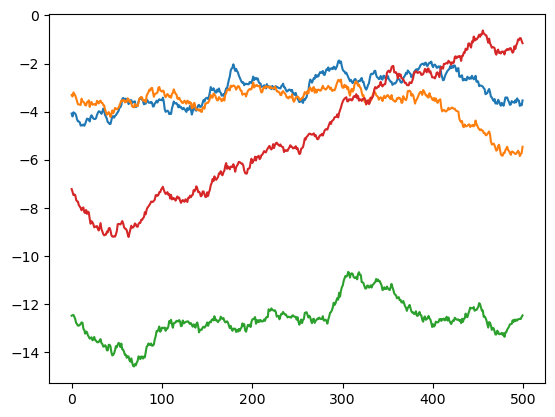

In [17]:
plt.plot(X_full[-500:, 0])
plt.plot(X_full[-500:, 1])
plt.plot(X_full[-500:, 2])
plt.plot(X_full[-500:, 3])
plt.show()